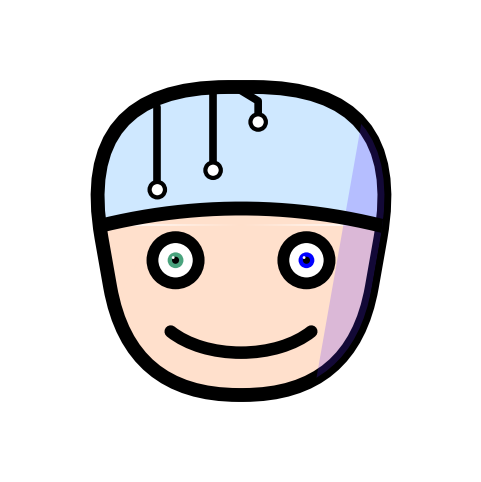

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.path import Path
from matplotlib.patches import PathPatch, Circle, Arc

# ----------------------------
# Face patch (rounded skewed rectangle)
# ----------------------------
def draw_face_patch(width, height, angle_top_to_bottom,
                    rounding_top, rounding_bottom,
                    cx=0.5, cy=0.5,
                    facecolor="none", edgecolor="black", lw=10,
                    zorder=20):
    theta = np.deg2rad(angle_top_to_bottom)
    dx = height * np.tan(theta)

    w_top = width
    w_bot = width + 2 * dx

    y_top = cy + height / 2
    y_bot = cy - height / 2

    tl = np.array([cx - w_top / 2, y_top])
    tr = np.array([cx + w_top / 2, y_top])
    br = np.array([cx + w_bot / 2, y_bot])
    bl = np.array([cx - w_bot / 2, y_bot])

    corners = [tl, tr, br, bl]  # clockwise
    r_corner = np.array([rounding_top, rounding_top, rounding_bottom, rounding_bottom], dtype=float)

    edge_len = [np.linalg.norm(corners[(i + 1) % 4] - corners[i]) for i in range(4)]
    for i in range(4):
        adj_min = min(edge_len[i - 1], edge_len[i])
        r_corner[i] = max(0.0, min(float(r_corner[i]), 0.49 * float(adj_min)))

    p_in, p_out = [], []
    for i in range(4):
        p = corners[i]
        p_prev = corners[i - 1]
        p_next = corners[(i + 1) % 4]
        r = float(r_corner[i])

        u_prev = (p_prev - p); u_prev /= np.linalg.norm(u_prev)
        u_next = (p_next - p); u_next /= np.linalg.norm(u_next)

        p_in.append(p + u_prev * r)
        p_out.append(p + u_next * r)

    verts, codes = [], []
    verts.append(tuple(p_out[0])); codes.append(Path.MOVETO)

    for i in [1, 2, 3]:
        verts.append(tuple(p_in[i]));     codes.append(Path.LINETO)
        verts.append(tuple(corners[i]));  codes.append(Path.CURVE3)
        verts.append(tuple(p_out[i]));    codes.append(Path.CURVE3)

    verts.append(tuple(p_in[0]));     codes.append(Path.LINETO)
    verts.append(tuple(corners[0]));  codes.append(Path.CURVE3)
    verts.append(tuple(p_out[0]));    codes.append(Path.CURVE3)

    verts.append((0.0, 0.0)); codes.append(Path.CLOSEPOLY)

    patch = PathPatch(
        Path(verts, codes),
        facecolor=facecolor,
        edgecolor=edgecolor,
        linewidth=lw,
        joinstyle="round",
        capstyle="round",
        zorder=zorder
    )
    return patch

# ----------------------------
# px->data conversions
# ----------------------------
def _px_to_data_dy(ax, px):
    inv = ax.transData.inverted()
    x0, y0 = inv.transform((0.0, 0.0))
    x1, y1 = inv.transform((0.0, float(px)))
    return (y1 - y0)

def _px_to_data_dx(ax, px):
    inv = ax.transData.inverted()
    x0, y0 = inv.transform((0.0, 0.0))
    x1, y1 = inv.transform((float(px), 0.0))
    return (x1 - x0)

# ----------------------------
# Get dense face boundary polygon in data coords
# ----------------------------
def _face_boundary_polygon(face_patch, interp=120):
    path_data = face_patch.get_path().transformed(face_patch.get_patch_transform())
    path_dense = path_data.interpolated(interp)
    polys = path_dense.to_polygons(closed_only=True)
    if not polys:
        raise ValueError("Could not extract polygon from face patch.")
    return max(polys, key=lambda a: a.shape[0])

# ----------------------------
# Build separator once (shared by fill + line)
# ----------------------------
def build_separator(ax, face_patch, cx=0.5, cy=0.5,
                    y_pos_px=15, curvature_px=35,
                    n=600, boundary_interp=200):
    ax.figure.canvas.draw()

    dy = _px_to_data_dy(ax, y_pos_px)
    dcurve = _px_to_data_dy(ax, curvature_px)
    y_sep = cy + dy

    poly = _face_boundary_polygon(face_patch, interp=boundary_interp)

    inter = []
    for i, ((x1, y1), (x2, y2)) in enumerate(zip(poly[:-1], poly[1:])):
        if (y1 <= y_sep <= y2) or (y2 <= y_sep <= y1):
            dyseg = (y2 - y1)
            if abs(dyseg) < 1e-12:
                continue
            t = (y_sep - y1) / dyseg
            if 0.0 <= t <= 1.0:
                x = x1 + t * (x2 - x1)
                inter.append({"x": float(x), "y": float(y_sep), "i": i, "t": float(t)})

    if len(inter) < 2:
        y_min = float(np.min(poly[:, 1])); y_max = float(np.max(poly[:, 1]))
        raise ValueError(
            f"Separator y={y_sep:.4f} did not intersect face. "
            f"Face y-range=[{y_min:.4f}, {y_max:.4f}]."
        )

    inter = sorted(inter, key=lambda d: d["x"])
    inter2 = [inter[0]]
    for d in inter[1:]:
        if abs(d["x"] - inter2[-1]["x"]) > 1e-6:
            inter2.append(d)
    if len(inter2) < 2:
        raise ValueError("Intersections collapsed after dedupe.")

    L, R = inter2[0], inter2[-1]

    p0 = np.array([L["x"], y_sep], dtype=float)
    p2 = np.array([R["x"], y_sep], dtype=float)
    pm = 0.5 * (p0 + p2)
    ctrl = np.array([pm[0], pm[1] + dcurve], dtype=float)

    t = np.linspace(0.0, 1.0, n)
    sep_pts = (1 - t)[:, None] ** 2 * p0 + 2 * (1 - t)[:, None] * t[:, None] * ctrl + t[:, None] ** 2 * p2
    return y_sep, sep_pts, L, R, poly

# ----------------------------
# Draw fills + separator line
# ----------------------------
def draw_face_brain(ax, face_patch,
                    cx=0.5, cy=0.5,
                    y_pos_px=15,
                    curvature_px=35,
                    sep_n=600,
                    boundary_interp=200,
                    fill_pad_px=0,
                    lw=10,
                    brain_color="#cfe8ff",
                    face_color="#ffe0cc",
                    line_color="black",
                    z_fill=10,
                    z_line=30):

    y_sep, sep_pts, L, R, poly = build_separator(
        ax, face_patch, cx=cx, cy=cy,
        y_pos_px=y_pos_px, curvature_px=curvature_px,
        n=sep_n, boundary_interp=boundary_interp
    )

    pad_dy = _px_to_data_dy(ax, fill_pad_px) if fill_pad_px else 0.0
    if pad_dy != 0.0:
        sep_top = sep_pts.copy(); sep_top[:, 1] -= abs(pad_dy)
        sep_bot = sep_pts.copy(); sep_bot[:, 1] += abs(pad_dy)
    else:
        sep_top = sep_pts
        sep_bot = sep_pts

    def arc_points(A, B):
        iA, iB = A["i"], B["i"]
        pts = [np.array([A["x"], A["y"]], dtype=float)]
        j = iA + 1
        N = len(poly) - 1
        while True:
            pts.append(poly[j % N].astype(float))
            if (j % N) == (iB % N):
                break
            j += 1
        pts[-1] = np.array([B["x"], B["y"]], dtype=float)
        return np.vstack(pts)

    arc_LR = arc_points(L, R)
    arc_RL = arc_points(R, L)

    if np.mean(arc_LR[:, 1]) >= np.mean(arc_RL[:, 1]):
        top_arc, bot_arc = arc_LR, arc_RL
    else:
        top_arc, bot_arc = arc_RL, arc_LR

    top_poly = np.vstack([top_arc, sep_top[::-1, :]])
    bot_poly = np.vstack([sep_bot, bot_arc[::-1, :]])

    def poly_to_patch(pts, color, z):
        verts = [tuple(pts[0])]
        codes = [Path.MOVETO]
        for p in pts[1:]:
            verts.append(tuple(p))
            codes.append(Path.LINETO)
        verts.append((0.0, 0.0)); codes.append(Path.CLOSEPOLY)
        patch = PathPatch(Path(verts, codes), facecolor=color, edgecolor="none", zorder=z)
        patch.set_clip_path(face_patch)
        ax.add_patch(patch)
        return patch

    face_fill = poly_to_patch(bot_poly, face_color, z_fill)
    brain_fill = poly_to_patch(top_poly, brain_color, z_fill + 1)

    line = mlines.Line2D(sep_pts[:, 0], sep_pts[:, 1],
                         lw=lw, color=line_color,
                         solid_capstyle="round",
                         zorder=z_line)
    line.set_clip_path(face_patch)
    ax.add_line(line)

    return brain_fill, face_fill, line

# ----------------------------
# Eyes
# ----------------------------
def add_eye(ax, cx, cy,
            open_eye=True,
            r=0.06,
            wink_lw=10,
            outline_color="black",
            iris_color="#49a37d",
            ring_ratio=0.10,
            iris_ratio=0.38,
            pupil_ratio=0.45,
            spec_ratio=0.18,
            spec_offset=(0.25, 0.25),
            iris_offset_y=0.0,
            aa_shrink=0.995,
            zorder=40):

    artists = []
    if open_eye:
        dy = iris_offset_y * r

        sclera = Circle((cx, cy), radius=r, facecolor="white", edgecolor="none", zorder=zorder)
        ax.add_patch(sclera); artists.append(sclera)

        rim = Circle((cx, cy), radius=r, facecolor="none", edgecolor=outline_color,
                     linewidth=wink_lw, zorder=zorder+1)
        ax.add_patch(rim); artists.append(rim)

        inner_r = r * (1.0 - ring_ratio)
        clip_r = inner_r * aa_shrink
        inner_clip = Circle((cx, cy), radius=clip_r, transform=ax.transData)

        ri = inner_r * float(iris_ratio)
        iris = Circle((cx, cy + dy), radius=ri, facecolor=iris_color, edgecolor="none", zorder=zorder+2)
        iris.set_clip_path(inner_clip)
        ax.add_patch(iris); artists.append(iris)

        rp = ri * float(pupil_ratio)
        pupil = Circle((cx, cy + dy), radius=rp, facecolor="black", edgecolor="none", zorder=zorder+3)
        pupil.set_clip_path(inner_clip)
        ax.add_patch(pupil); artists.append(pupil)

        rs = ri * float(spec_ratio)
        ox, oy = spec_offset
        spec = Circle((cx - ox*ri, cy + dy + oy*ri), radius=rs, facecolor="white", edgecolor="none", zorder=zorder+4)
        spec.set_clip_path(inner_clip)
        ax.add_patch(spec); artists.append(spec)

        return artists

    wink = Arc((cx, cy), width=2*r, height=1.15*r,
               angle=0, theta1=200, theta2=340,
               color=outline_color, linewidth=wink_lw,
               capstyle="round", zorder=zorder)
    ax.add_patch(wink); artists.append(wink)
    return artists

def draw_eyes(ax, face_patch,
              cx=0.5, cy=0.5,
              open_left=True, open_right=True,
              eye_dx=0.17,
              eye_dy=-0.05,
              r=0.06,
              wink_lw=10,
              outline_color="black",
              iris_color_left="#49a37d",
              iris_color_right="#49a37d",
              ring_ratio=0.10,
              iris_ratio=0.38,
              pupil_ratio=0.45,
              spec_ratio=0.18,
              spec_offset=(0.30, 0.34),
              iris_offset_y=0.0,
              aa_shrink=0.995,
              zorder=40,
              clip=True):

    left_x, left_y   = (cx - eye_dx, cy + eye_dy)
    right_x, right_y = (cx + eye_dx, cy + eye_dy)

    left_artists = add_eye(
        ax, left_x, left_y, open_eye=open_left,
        r=r, wink_lw=wink_lw,
        outline_color=outline_color,
        iris_color=iris_color_left,
        ring_ratio=ring_ratio,
        iris_ratio=iris_ratio,
        pupil_ratio=pupil_ratio,
        spec_ratio=spec_ratio,
        spec_offset=spec_offset,
        iris_offset_y=iris_offset_y,
        aa_shrink=aa_shrink,
        zorder=zorder
    )

    right_artists = add_eye(
        ax, right_x, right_y, open_eye=open_right,
        r=r, wink_lw=wink_lw,
        outline_color=outline_color,
        iris_color=iris_color_right,
        ring_ratio=ring_ratio,
        iris_ratio=iris_ratio,
        pupil_ratio=pupil_ratio,
        spec_ratio=spec_ratio,
        spec_offset=spec_offset,
        iris_offset_y=iris_offset_y,
        aa_shrink=aa_shrink,
        zorder=zorder
    )

    if clip:
        for a in left_artists + right_artists:
            a.set_clip_path(face_patch)

    return left_artists, right_artists

# ----------------------------
# Smile
# ----------------------------
def add_smile(ax, face_patch,
              cx=0.5, cy=0.5,
              y=-0.18,
              w=0.42,
              h=0.26,
              theta1=200, theta2=340,
              color="black",
              lw=10,
              zorder=45,
              clip=True):
    smile = Arc((cx, cy + y), width=w, height=h,
                angle=0, theta1=theta1, theta2=theta2,
                color=color, linewidth=lw, capstyle="round",
                zorder=zorder)
    if clip:
        smile.set_clip_path(face_patch)
    ax.add_patch(smile)
    return smile

# ----------------------------
# Face-follow crescent shading using x_center +/- n gating
# ----------------------------
def add_face_follow_crescent(ax, face_patch,
                             side="right",
                             color="#5b2cff",
                             alpha=0.22,
                             width_frac=0.10,
                             margin_frac=0.06,
                             smooth_window=11,
                             zorder=28):
    path = face_patch.get_path().transformed(face_patch.get_patch_transform())
    dense = path.interpolated(300).to_polygons(closed_only=True)
    if not dense:
        return None
    poly = max(dense, key=len)

    xmin, ymin = poly.min(axis=0)
    xmax, ymax = poly.max(axis=0)
    W = float(xmax - xmin)

    x_center = 0.5 * (xmin + xmax)
    n = float(margin_frac) * W

    side = side.lower().strip()
    if side not in ("left", "right"):
        raise ValueError("side must be 'left' or 'right'")

    if side == "right":
        mask = poly[:, 0] > (x_center + n)
        inward_sign = -1.0
    else:
        mask = poly[:, 0] < (x_center - n)
        inward_sign = +1.0

    idx = np.nonzero(mask)[0]
    if len(idx) < 20:
        return None

    breaks = np.where(np.diff(idx) != 1)[0] + 1
    runs = np.split(idx, breaks)
    run = max(runs, key=len)
    edge = poly[run]

    def smooth(a, win):
        win = int(win)
        if win < 3 or win % 2 == 0 or len(a) < win:
            return a
        pad = win // 2
        ap = np.vstack([a[0:1].repeat(pad, axis=0), a, a[-1:].repeat(pad, axis=0)])
        ker = np.ones(win) / win
        xs = np.convolve(ap[:, 0], ker, mode="valid")
        ys = np.convolve(ap[:, 1], ker, mode="valid")
        return np.c_[xs, ys]

    edge = smooth(edge, smooth_window)

    thick = float(width_frac) * W
    inner = edge.copy()
    inner[:, 0] = inner[:, 0] + inward_sign * thick

    band = np.vstack([edge, inner[::-1, :]])

    verts = [tuple(band[0])]
    codes = [Path.MOVETO]
    for p in band[1:]:
        verts.append(tuple(p))
        codes.append(Path.LINETO)
    verts.append((0.0, 0.0)); codes.append(Path.CLOSEPOLY)

    patch = PathPatch(Path(verts, codes),
                      facecolor=color, edgecolor="none",
                      alpha=alpha, zorder=zorder)
    patch.set_clip_path(face_patch)
    ax.add_patch(patch)
    return patch

def add_one_brain_circuit_from_brain_top(ax, brain_fill,
                                        center_shift=0.0,   # fraction of brain width
                                        length_px=78,       # pixels downward from the top edge
                                        node_r=0.020,
                                        node_facecolor="white",
                                        node_edgecolor="black",
                                        wire_color="black",
                                        wire_lw=7,          # points
                                        zorder=26,
                                        cap_safety=1.10):

    def top_y_at_x_from_poly(poly_xy, xq, eps=1e-9):
        # ensure closed loop (so last->first is included)
        if not np.allclose(poly_xy[0], poly_xy[-1]):
            poly_xy = np.vstack([poly_xy, poly_xy[0]])

        ys = []
        for (x1, y1), (x2, y2) in zip(poly_xy[:-1], poly_xy[1:]):
            dx = x2 - x1

            # vertical edge: if x matches the vertical line, include both endpoints
            if abs(dx) <= eps:
                if abs(xq - x1) <= eps:
                    ys.append(float(y1))
                    ys.append(float(y2))
                continue

            # xq within segment x-range (with tolerance)
            if (min(x1, x2) - eps) <= xq <= (max(x1, x2) + eps):
                t = (xq - x1) / dx
                if (-eps) <= t <= (1.0 + eps):
                    ys.append(float(y1 + t * (y2 - y1)))

        if not ys:
            return None
        return max(ys)  # top intersection y at xq

    # brain polygon in data coords
    brain_path = brain_fill.get_path().transformed(brain_fill.get_patch_transform())
    polys = brain_path.to_polygons(closed_only=True)
    if not polys:
        return None, None
    poly = max(polys, key=len)

    xmin, ymin = poly.min(axis=0)
    xmax, ymax = poly.max(axis=0)
    W = float(xmax - xmin)

    # x position relative to brain center
    x_center = 0.5 * (xmin + xmax)
    x = float(x_center + float(center_shift) * W)

    # y value of the brain edge at this x
    y_top = top_y_at_x_from_poly(poly, x)
    if y_top is None:
        return None, None

    # start a bit above edge; clip makes it look perfectly attached
    cap_radius_px = (float(wire_lw) * ax.figure.dpi / 72.0) * 0.5
    cap_dy = abs(_px_to_data_dy(ax, cap_radius_px * float(cap_safety)))
    y_start = float(y_top + cap_dy)

    # end point: go DOWN into the brain
    dy = abs(_px_to_data_dy(ax, float(length_px)))
    y_end = float(y_top - dy)

    # draw wire (clipped)
    wire = mlines.Line2D([x, x], [y_start, y_end],
                         lw=wire_lw, color=wire_color,
                         solid_capstyle="round",
                         zorder=zorder)
    wire.set_clip_path(brain_fill)
    ax.add_line(wire)

    # draw node (clipped)
    node = Circle((x, y_end), node_r,
                  facecolor=node_facecolor,
                  edgecolor=node_edgecolor,
                  linewidth=float(wire_lw) * 0.55,
                  zorder=zorder + 1)
    node.set_clip_path(brain_fill)
    ax.add_patch(node)

    return node, wire


def add_bent_brain_circuit_from_face_outline(ax, face_patch,
                                            cx=0.5, cy=0.5,
                                            # MUST match how you built the brain region:
                                            y_pos_px=15,
                                            curvature_px=35,
                                            boundary_interp=220,
                                            sep_n=700,
                                            fill_pad_px=2,

                                            # wire geometry
                                            center_shift=0.0,      # fraction of brain width
                                            length_px=90,          # pixels downward into brain
                                            bend_px=28,            # pixels sideways at bend
                                            bend_at=0.45,          # 0..1 where bend happens along length

                                            # node + style
                                            node_r=0.020,
                                            node_facecolor="white",
                                            node_edgecolor="black",
                                            wire_color="black",
                                            wire_lw=7,             # points
                                            zorder=26,
                                            cap_safety=1.10):
    """
    Bent brain circuit that RECEIVES face_patch (face_outline) and clips wire+node to the computed brain region.
    """

    # --- recompute the brain region polygon (top half) exactly like draw_face_brain ---
    y_sep, sep_pts, L, R, poly = build_separator(
        ax, face_patch, cx=cx, cy=cy,
        y_pos_px=y_pos_px, curvature_px=curvature_px,
        n=sep_n, boundary_interp=boundary_interp
    )

    pad_dy = _px_to_data_dy(ax, fill_pad_px) if fill_pad_px else 0.0
    if pad_dy != 0.0:
        sep_top = sep_pts.copy()
        sep_top[:, 1] -= abs(pad_dy)
    else:
        sep_top = sep_pts

    def arc_points(A, B):
        iA, iB = A["i"], B["i"]
        pts = [np.array([A["x"], A["y"]], dtype=float)]
        j = iA + 1
        N = len(poly) - 1
        while True:
            pts.append(poly[j % N].astype(float))
            if (j % N) == (iB % N):
                break
            j += 1
        pts[-1] = np.array([B["x"], B["y"]], dtype=float)
        return np.vstack(pts)

    arc_LR = arc_points(L, R)
    arc_RL = arc_points(R, L)

    # choose which arc is the "top" boundary
    if np.mean(arc_LR[:, 1]) >= np.mean(arc_RL[:, 1]):
        top_arc = arc_LR
    else:
        top_arc = arc_RL

    # brain top polygon = top arc + separator curve back
    top_poly = np.vstack([top_arc, sep_top[::-1, :]])

    # make an invisible clip patch for the brain region
    verts = [tuple(top_poly[0])]
    codes = [Path.MOVETO]
    for p in top_poly[1:]:
        verts.append(tuple(p))
        codes.append(Path.LINETO)
    verts.append((0.0, 0.0))
    codes.append(Path.CLOSEPOLY)

    brain_clip = PathPatch(Path(verts, codes), facecolor="none", edgecolor="none")
    brain_clip.set_clip_path(face_patch)

    brain_clip.set_alpha(0.0)
    brain_clip.set_zorder(-999)
    ax.add_patch(brain_clip)


    # --- pick a start x relative to the brain width ---
    xmin, ymin = top_poly.min(axis=0)
    xmax, ymax = top_poly.max(axis=0)
    W = float(xmax - xmin)
    x_center = 0.5 * (xmin + xmax)
    x0 = float(x_center + float(center_shift) * W)

    # --- find the top edge y at x0 by intersecting with top_arc segments ---
    def top_y_at_x(polyline_xy, xq, eps=1e-9):
        ys = []
        for (x1, y1), (x2, y2) in zip(polyline_xy[:-1], polyline_xy[1:]):
            dx = x2 - x1
            if abs(dx) <= eps:
                if abs(xq - x1) <= eps:
                    ys.append(float(y1)); ys.append(float(y2))
                continue
            if (min(x1, x2) - eps) <= xq <= (max(x1, x2) + eps):
                t = (xq - x1) / dx
                if (-eps) <= t <= (1.0 + eps):
                    ys.append(float(y1 + t * (y2 - y1)))
        return max(ys) if ys else None

    y_top = top_y_at_x(top_arc, x0)
    if y_top is None:
        return None, None

    # start slightly above edge so the cap looks attached
    cap_radius_px = (float(wire_lw) * ax.figure.dpi / 72.0) * 0.5
    cap_dy = abs(_px_to_data_dy(ax, cap_radius_px * float(cap_safety)))
    y0 = float(y_top + cap_dy)

    # geometry in data units
    dy_total = abs(_px_to_data_dy(ax, float(length_px)))
    dx_bend  = _px_to_data_dx(ax, float(bend_px))

    y1 = float(y_top - dy_total * float(bend_at))
    x1 = float(x0 + dx_bend)

    y2 = float(y_top - dy_total)
    x2 = float(x1)

    # wire (2-segment polyline) clipped to brain region
    wire = mlines.Line2D([x0, x1, x2], [y0, y1, y2],
                         lw=wire_lw, color=wire_color,
                         solid_capstyle="round",
                         solid_joinstyle="round",
                         zorder=zorder)
    wire.set_clip_path(brain_clip)
    ax.add_line(wire)

    # node at the end, clipped to brain region
    node = Circle((x2, y2), node_r,
                  facecolor=node_facecolor,
                  edgecolor=node_edgecolor,
                  linewidth=float(wire_lw) * 0.55,
                  zorder=zorder + 1)
    node.set_clip_path(brain_clip)
    ax.add_patch(node)

    return node, wire


# ----------------------------
# Demo
# ----------------------------
if __name__ == "__main__":
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect("equal")
    ax.axis("off")

    phi = (1 + 5**0.5) / 3
    height = 0.8
    width = height * phi
    lw_big = 10

    face_outline = draw_face_patch(
        width=width, height=height,
        angle_top_to_bottom=-10,
        rounding_top=0.5,
        rounding_bottom=0.3,
        cx=0.5, cy=0.5,
        facecolor="none",
        edgecolor="black",
        lw=lw_big,
        zorder=20
    )
    ax.add_patch(face_outline)

    brain_fill, face_fill, sep_line = draw_face_brain(
        ax, face_outline,
        cx=0.5, cy=0.5,
        y_pos_px=15,
        curvature_px=35,
        fill_pad_px=2,
        sep_n=700,
        boundary_interp=220,
        lw=lw_big,
        brain_color="#cfe8ff",
        face_color="#ffe0cc",
        line_color="black"
    )

    add_face_follow_crescent(
        ax, face_outline,
        side="right",
        color="#5b2cff",
        alpha=0.22,
        width_frac=0.11,
        margin_frac=0.06,
        smooth_window=11,
        zorder=28
    )
    add_one_brain_circuit_from_brain_top(
        ax, face_outline,
        center_shift=-0.3,          # middle like your red
        length_px=78,
        node_r=0.020,
        node_facecolor="white",
        node_edgecolor="black",
        wire_lw=lw_big * 0.55,
        zorder=26
    )
    
    add_one_brain_circuit_from_brain_top(
        ax, face_outline,
        center_shift=-0.1,          # middle like your red
        length_px=78,
        node_r=0.020,
        node_facecolor="white",
        node_edgecolor="black",
        wire_lw=lw_big * 0.55,
        zorder=26
    )
    add_bent_brain_circuit_from_face_outline(
        ax, face_outline,
        center_shift=-0,
        length_px=35,
        bend_px=30,
        bend_at=0.40,
        node_r=0.020,
        wire_lw=lw_big * 0.55,
        zorder=26
    )


    draw_eyes(
        ax, face_outline,
        cx=0.5, cy=0.5,
        open_left=True, open_right=True,
        eye_dx=0.17, eye_dy=-0.05,
        r=0.06,
        wink_lw=lw_big * 0.85,
        outline_color="black",
        iris_color_left="#49a37d",
        iris_color_right="blue",
        ring_ratio=0.10,
        iris_ratio=0.38,
        pupil_ratio=0.45,
        spec_ratio=0.18,
        iris_offset_y=0.0,
        aa_shrink=0.995
    )

    add_smile(
        ax, face_outline,
        cx=0.5, cy=0.5,
        y=-0.15,
        w=0.46, h=0.28,
        theta1=205, theta2=335,
        lw=lw_big * 0.9
    )

    plt.show()
